In [172]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
#Load in Training and Test Data
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')

# Separate Training data into attributes and labels
X = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]

In [174]:
# Save id column for later csv creation
id_col = test_data['id']
# Remove nominal/categorical data from both sets
numeric_attributes = X.select_dtypes(include='number').columns

X = X[numeric_attributes]
test_data = test_data[numeric_attributes]

In [175]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
print(X.head())


         id  num_critic_for_reviews  duration  director_facebook_likes  \
0 -1.731474                0.168193 -1.692456                -0.251113   
1 -1.730321                0.712593 -0.596914                -0.260477   
2 -1.729168                0.547624  0.316038                -0.182223   
3 -1.728015                1.083775 -0.049143                -0.260477   
4 -1.726862                1.083775  2.781008                -0.260477   

   actor_3_facebook_likes  actor_1_facebook_likes     gross  num_voted_users  \
0                0.041616               -0.343014  5.423388         3.576467   
1               -0.281257               -0.424659 -0.459765        -0.172501   
2               -0.287568                0.263561 -0.753112        -0.453535   
3               -0.327532               -0.406280 -0.557017         1.015541   
4                0.046874                0.506190  3.830379         7.517258   

   cast_total_facebook_likes  facenumber_in_poster  num_user_for_reviews  

In [176]:
#chosen_model = GradientBoostingClassifier()
#chosen_model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=150)
#chosen_model = RandomForestClassifier()
#chosen_model = LogisticRegression(max_iter=10000)
#base_classifier = DecisionTreeClassifier()
#chosen_model = BaggingClassifier(base_classifier, n_estimators=80, random_state=42)
base_estimators = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=10000)),
]
chosen_model = StackingClassifier(estimators=base_estimators,final_estimator=LogisticRegression(max_iter=10000), cv=5)


In [177]:
chosen_model.fit(X, y)

StackingClassifier(cv=5,
                   estimators=[('gradient_boosting',
                                GradientBoostingClassifier(n_estimators=200,
                                                           random_state=42)),
                               ('random_forest',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=10000))],
                   final_estimator=LogisticRegression(max_iter=10000))

In [164]:
# Evaluate performance of model using k-folds cross validation
k_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(chosen_model, X, y, cv=k_folds)

print("K-Folds Accuracies:", cv_scores)
print("K-Folds Mean Accuracy:", cv_scores.mean())

K-Folds Accuracies: [0.68770764 0.72757475 0.71096346 0.68106312 0.71       0.67666667
 0.69       0.68666667 0.68666667 0.66666667]
K-Folds Mean Accuracy: 0.6923975636766334


In [178]:
# Train and make test set predictions for Kaggle
predictions = chosen_model.predict(test_data)
predictions_df = pd.DataFrame({'id': id_col, 'imdb_score_binned': predictions})
predictions_df.to_csv('predictions.csv', index=False)

In [167]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
# Grid Search to tune hyperparameters
# Define parameter grid
param_grid = {
    'n_estimators': [10, 40, 80, 150],
}

# Perform grid search
grid_search = GridSearchCV(chosen_model, param_grid=param_grid, cv=k_folds, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

ValueError: Invalid parameter 'n_estimators' for estimator LogisticRegression(max_iter=1000). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

Confusion Matrix:
[[  0   0   5   0   0]
 [  0   6  42   0   0]
 [  0   4 343  30   0]
 [  0   0  60  88   4]
 [  0   0   1   7  11]]


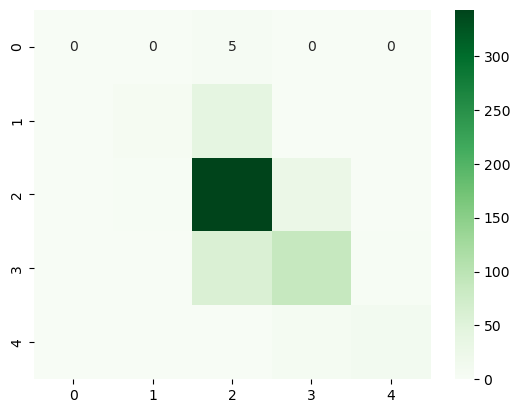

In [168]:
# Use a confusion matrix to get performance
chosen_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = chosen_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
plt.show()